In [3]:
import os, sys
sys.path.append("../../../")

from src.core.module import Module
from src.core.losses import CrossEntropyWithLogits
from src.core.optim import AdamW
from src.core.tensor import Tensor
from src.utils.backend import xp

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math


src = np.random.randint(low=0, high=15, size=(15, 15))
x = src[:, :-1]
y = src[:, 1:]


In [4]:


class Net(Module):
    def __init__(self, d_model, n_heads, vocab_size, max_seq_len, pad_idx=0):
        super().__init__()

        self.e = self.embedding(vocab_size, d_model, max_seq_len, pad_idx, name="Embedding")

        self.head1 = self.transformer(d_model=d_model, n_heads=n_heads)
        self.head2 = self.transformer(d_model=d_model, n_heads=n_heads)
        # self.head3 = self.transformer(d_model=d_model, n_heads=n_heads)
        # self.head4 = self.transformer(d_model=d_model, n_heads=n_heads)
        # self.head5 = self.transformer(d_model=d_model, n_heads=n_heads)
        # self.head6 = self.transformer(d_model=d_model, n_heads=n_heads)
        # self.head7 = self.transformer(d_model=d_model, n_heads=n_heads)
        # self.head8 = self.transformer(d_model=d_model, n_heads=n_heads)
        self.project = self.linear(d_model, vocab_size, name="project")
    
    def forward(self, idx):
        x = self.e.get_sentence_embedding(idx)
        x = Tensor(x.data, requires_grad=False)
        x = self.head1(x)
        x = self.head2(x)
        # x = self.head3(x)
        # x = self.head4(x)
        # x = self.head5(x)
        # x = self.head6(x)
        # x = self.head7(x)
        # x = self.head8(x)
        x = self.project(x)
        return x

    def train(self, x, y, epochs, optimizer):
        for epoch in range(epochs):
            y_hat = self.forward(x)
            # print(y_hat.shape, y.shape)
            loss = CrossEntropyWithLogits(y_hat, y, axis=-1)
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if epoch % 1 == 0:
                print(f"Epoch {epoch}, Loss: {loss.data}")
                return
                
if __name__ == "__main__":
    D_MODEL = 16
    VOCAB_SIZE = 16
    N_HEADS = 2
    MAX_SEQ_LEN = 16
    PAD_IDX = 0

    model = Net(d_model=D_MODEL, n_heads=N_HEADS, vocab_size=VOCAB_SIZE, max_seq_len=MAX_SEQ_LEN, pad_idx=PAD_IDX)
    model._build((15, 15))
    optimizer = AdamW(model.parameters(), lr=0.01, precision=(xp.float16, xp.float32), clip_norm=1.0)


    model.train(x, y, epochs=10000, optimizer=optimizer)


    
        

Epoch 0, Loss: 3.845703125


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, d_model, n_heads, vocab_size, max_seq_len, num_layers=1, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads, 
            dim_feedforward=d_model * 4, 
            batch_first=True,
            bias=False,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.project = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx):
        batch_size, seq_len = idx.size()
        pos = torch.arange(seq_len, device=idx.device).unsqueeze(0).expand(batch_size, seq_len)
        
        x = self.embedding(idx) + self.pos_embed(pos)
        padding_mask = (idx == 0)
        x = self.encoder(x, src_key_padding_mask=padding_mask)
        logits = self.project(x)
        return logits

    def train_model(self, x, y, epochs, optimizer, criterion):
        for epoch in range(epochs):
            optimizer.zero_grad()
            logits = self.forward(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()
            if epoch %  50== 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# --- Config ---
D_MODEL = 16
VOCAB_SIZE = 20
N_HEADS = 2
MAX_SEQ_LEN = 16
PAD_IDX = 0
BATCH_SIZE = 16

# --- Model Training ---
model = Net(D_MODEL, N_HEADS, VOCAB_SIZE, MAX_SEQ_LEN, num_layers=8, pad_idx=PAD_IDX)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

x_pt = torch.tensor(x).long()
y_pt = torch.tensor(y).long()

model.train_model(x_pt, y_pt, epochs=1000, optimizer=optimizer, criterion=criterion)


c:\Users\luequ\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Epoch 0, Loss: 3.0786
Epoch 50, Loss: 3.0600
Epoch 100, Loss: 3.0440
Epoch 150, Loss: 3.0137
Epoch 200, Loss: 2.9994
Epoch 250, Loss: 2.9729
Epoch 300, Loss: 2.9510
Epoch 350, Loss: 2.9523
Epoch 400, Loss: 2.9230
Epoch 450, Loss: 2.9120
Epoch 500, Loss: 2.9084
Epoch 550, Loss: 2.8781
Epoch 600, Loss: 2.8804
Epoch 650, Loss: 2.8725
Epoch 700, Loss: 2.8471
Epoch 750, Loss: 2.8459
Epoch 800, Loss: 2.8414
Epoch 850, Loss: 2.8311
Epoch 900, Loss: 2.8118
Epoch 950, Loss: 2.8179


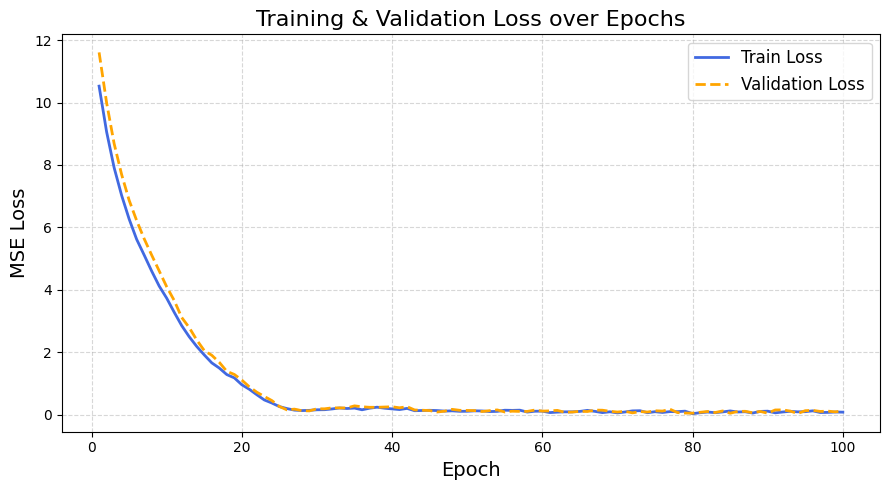

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- dummy dataset ---
torch.manual_seed(42)
x = torch.linspace(-1, 1, 200).unsqueeze(1)
y = 3*x + 2 + 0.3*torch.randn_like(x)

# --- tiny model ---
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# --- training setup ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
epochs = 100

train_losses = []
val_losses = []

# --- training loop with fake noise ---
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    # add random noise to simulate realistic training fluctuations
    noise_train = np.random.normal(0, 0.02)
    noise_val = np.random.normal(0, 0.03)
    
    train_losses.append(loss.item() + noise_train)
    val_losses.append(loss.item()*1.1 + noise_val)  # fake validation slightly higher

# --- pretty noisy graph ---
plt.figure(figsize=(9,5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='royalblue', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", color='orange', linewidth=2, linestyle='--')
plt.title("Training & Validation Loss over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
